In [1]:
import streamlit as st
import pandas as pd
import pickle
import requests
import json
import joblib
import numpy as np
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import folium
from streamlit_folium import st_folium
import plotly.express as px
import missingno as msno
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold,train_test_split
from sklearn.metrics import precision_score,confusion_matrix
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df=pd.read_csv("solar.csv")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
WindSpeed,8760.0,2.639823,1.628754,0.0,1.4,2.3,3.60000,10.9
Sunshine,8760.0,11.180479,21.171295,0.0,0.0,0.0,7.00000,60.0
AirPressure,8760.0,1010.361781,12.793971,965.9,1002.8,1011.0,1018.20000,1047.3
Radiation,8760.0,97.538493,182.336029,-9.3,-6.2,-1.4,115.60000,899.7
AirTemperature,8760.0,6.978893,7.604266,-12.4,0.5,6.4,13.40000,27.1
RelativeAirHumidity,8760.0,76.719406,19.278996,13.0,64.0,82.0,93.00000,100.0
SystemProduction,8760.0,684.746071,1487.454665,0.0,0.0,0.0,464.24995,7701.0


In [3]:
df.head()

,Date-Hour,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


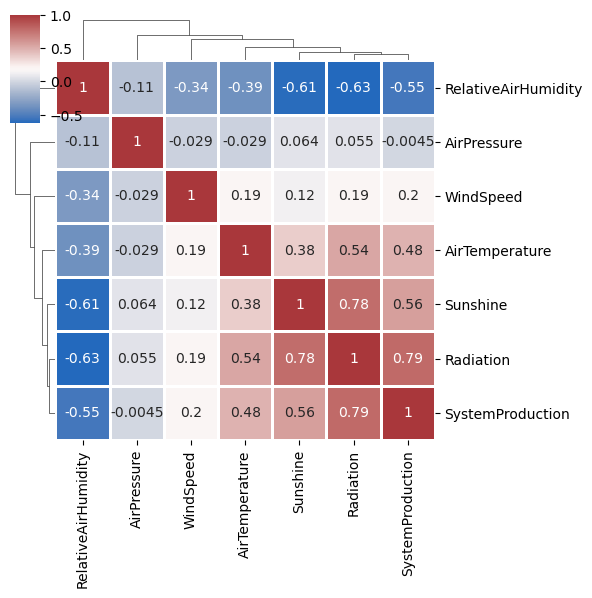

In [4]:
y_df=df.drop(["Date-Hour"],axis=1)
sns.clustermap(y_df.corr(), cmap="vlag",dendrogram_ratio=(0.1,0.1), annot=True,linewidths=0.8,figsize=(6,6))
plt.show()

In [9]:
Y=df["SystemProduction"]
X=y_df.drop(["SystemProduction"],axis=1)
X

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity
0,0.6,0,1003.8,-7.4,0.1,97
1,1.7,0,1003.5,-7.4,-0.2,98
2,0.6,0,1003.4,-6.7,-1.2,99
3,2.4,0,1003.3,-7.2,-1.3,99
4,4.0,0,1003.1,-6.3,3.6,67
...,...,...,...,...,...,...
8755,4.1,0,988.2,-4.8,-0.7,94
8756,2.1,0,987.3,-5.0,-0.3,95
8757,1.8,0,986.7,-5.3,0.2,93
8758,2.2,0,986.0,-5.4,0.3,92


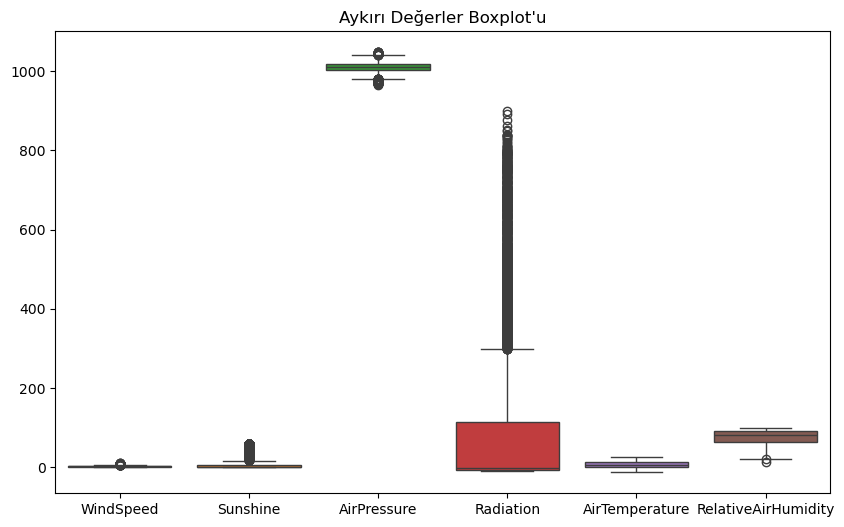

In [19]:
#görselleştirme
# Aykırı değerler için Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.title("Aykırı Değerler Boxplot'u")
plt.show()

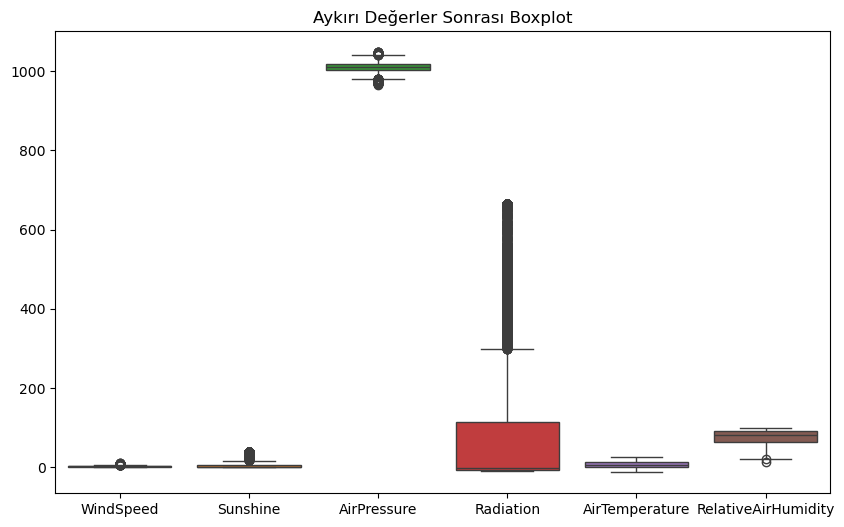

In [21]:
# IQR ile aykırı değerleri clip etme
# IQR ile aykırı değerleri clip etme
Q1 = np.percentile(X, 25,axis=0)
Q3 = np.percentile(X, 75,axis=0)
IQR = Q3 - Q1

# Aykırı değerleri clip etme
x_clipped = np.clip(X, Q1 - 4.5 * IQR, Q3 + 4.5 * IQR)
# Clip edilmiş verinin Boxplot'u
plt.figure(figsize=(10, 6))
sns.boxplot(data=x_clipped)
plt.title("Aykırı Değerler Sonrası Boxplot")
plt.show()

In [32]:
X_train,X_test,y_train,y_test=train_test_split(x_clipped,Y,test_size=0.3,random_state=42)
#istenilen aralığa sıkıştırır
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler(feature_range=(0,1))
x_train=scaler.fit_transform(X_train)
x_test= scaler.transform(X_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Model: lr
Best Parameters: {'fit_intercept': True}
Best MSE: -820533.1567347065
R² Score: 0.6119594710722518

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model: Ridge
Best Parameters: {'alpha': 1, 'solver': 'auto'}
Best MSE: -820524.0370205061
R² Score: 0.6121836149024997

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model: Lasso
Best Parameters: {'alpha': 0.1}
Best MSE: -820536.5503129516
R² Score: 0.6120143158080991

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model: SVR
Best Parameters: {'C': 10, 'kernel': 'linear'}
Best MSE: -1154618.6859166927
R² Score: 0.509458209246696

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model: RF
Best Parameters: {'max_depth': None, 'n_estimators': 200}
Best MSE: -638916.6460668633
R² Score: 0.7219086487040698

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Model: GBM
Best Parameters: {'learning_rate': 0.05, 'max_dept

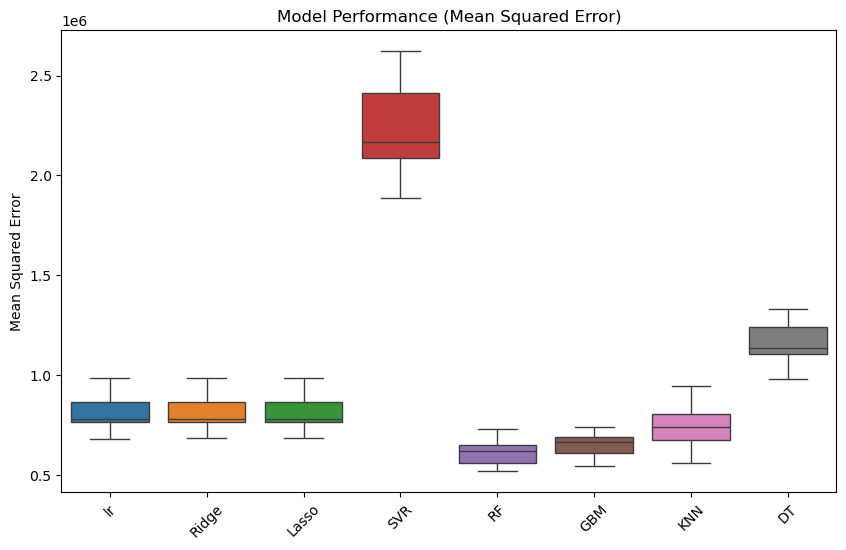

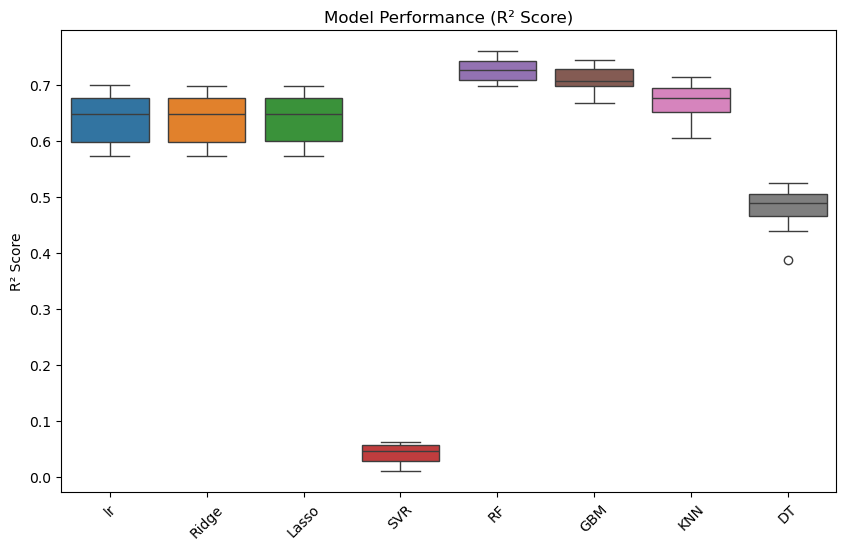

ValueError: too many values to unpack (expected 4)

In [33]:
#reg için best
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Veri yükleme (örnek olarak)
# df = pd.read_csv('data.csv')
# x = df.drop('target_column', axis=1)
# y = df['target_column']

def getmodels():
    models = []
    models.append(("lr", LinearRegression()))
    models.append(("Ridge", Ridge()))
    models.append(("Lasso", Lasso()))
    models.append(("SVR", SVR()))
    models.append(("RF", RandomForestRegressor()))
    models.append(("GBM", GradientBoostingRegressor()))
    models.append(("KNN", KNeighborsRegressor()))
    models.append(("DT", DecisionTreeRegressor()))
    return models

from sklearn.metrics import r2_score

def grid_search_regression(models, x_train, y_train):
    best_models = []
    
    for name, model in models:
        if name == "lr":
            param_grid = {'fit_intercept': [True, False]}
        elif name == "Ridge":
            param_grid = {'alpha': [0.1, 1, 10], 'solver': ['auto', 'svd', 'cholesky']}
        elif name == "Lasso":
            param_grid = {'alpha': [0.1, 1, 10]}
        elif name == "SVR":
            param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        elif name == "RF":
            param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None]}
        elif name == "GBM":
            param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7]}
        elif name == "KNN":
            param_grid = {'n_neighbors': [3, 5, 7, 10], 'metric': ['euclidean', 'manhattan']}
        elif name == "DT":
            param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}

        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
        grid_search.fit(x_train, y_train)

        # En iyi modelin test setinde performansını ölç
        y_pred = grid_search.best_estimator_.predict(x_test)
        r2 = r2_score(y_test, y_pred)

        print(f"Model: {name}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best MSE: {grid_search.best_score_}")
        print(f"R² Score: {r2}\n")

        best_models.append((name, grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, r2))
    
    return best_models


def modelstrain(x_train, y_train, models):
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10)
        mse_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring="neg_mean_squared_error")
        r2_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring="r2")
        
        results.append(mse_scores)
        names.append(name)
        print(f"{name}: MSE: {-mse_scores.mean()}, std: {mse_scores.std()}, R²: {r2_scores.mean()}")

    return names, results


def plot_box(names, results):
    df = pd.DataFrame({names[i]: -results[i] for i in range(len(names))})
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title("Model Performance (Mean Squared Error)")
    plt.ylabel("Mean Squared Error")
    plt.xticks(rotation=45)
    plt.show()

def plot_r2_box(names, r2_results):
    df = pd.DataFrame({names[i]: r2_results[i] for i in range(len(names))})
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title("Model Performance (R² Score)")
    plt.ylabel("R² Score")
    plt.xticks(rotation=45)
    plt.show()


# Modelleri ve isimleri al
models = getmodels()

# Model parametreleriyle GridSearchCV işlemi
# Bu adımı sadece eğitimi önce yapıp, en iyi modelleri bulmak için çağırabilirsiniz.
best_models = grid_search_regression(models, x_train, y_train)

# En iyi model parametrelerini belirle
best_models = grid_search_regression(models, x_train, y_train)

# Boxplot görsellemesi
plot_box(names, results)

r2_results = [cross_val_score(model, x_train, y_train, cv=10, scoring="r2") for _, model in models]
plot_r2_box(names, r2_results)


# En iyi modelleri yazdır
for name, model, best_params, best_score in best_models:
    print(f"Best Model: {name}")
    print(f"Best Parameters: {best_params}")
    print(f"Best MSE: {best_score}\n")


In [34]:
import pickle
from sklearn.ensemble import RandomForestRegressor

# En iyi modeli belirle
best_model = RandomForestRegressor(max_depth=None, n_estimators=200)

# Modeli eğit
best_model.fit(x_train, y_train)

# Modeli kaydet
with open("best_rf_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

print("Model başarıyla kaydedildi!")

Model başarıyla kaydedildi!


In [35]:
# Modeli yükle
with open("best_rf_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# Tahmin yap
predictions = loaded_model.predict(x_test)

# Performans değerlendirme
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test MSE: {mse}")
print(f"Test R² Score: {r2}")


Test MSE: 564048.8704484785
Test R² Score: 0.7246812731962012
